# Generating Fake Books for Training

It is difficult to infer anthology contents and other whole/part relationships at large scales. This notebook generates fake books to mimic those relationships.

Specifically, it generates:

- Input: Multi-volume works; Output: Fake single volume of work
- Input: A long single volume work; Output: Multiple fake volumes for parts of work (not yet implemented)
- Input: Multiple works by the same author; Output: An 'works'-style anthology

#### Workflow information
As of Apr 2020, the process for running this is 
- Generate the files and ground truth by running this notebook
- Convert the `fake` files to Vector_files, using `vectorization.py`
- Concatenate the Vector_files with the real data, using the concatenate script in compare_tools

In [22]:
from gensim.models import KeyedVectors
wem_model = KeyedVectors.load('/data/glove/glove.840B-300d.wv', mmap='r')

In [48]:
vecs = wem_model[['a','b','c']]
weights = [1,2,3]
a = np.average(vecs, weights=weights, axis=0)[:10] * sum(weights)
b = np.dot(vecs.T, weights)[:10]

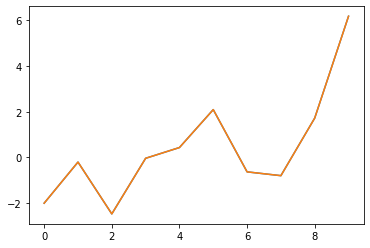

In [49]:
ax = pd.Series(a).plot()
pd.Series(b).plot(ax=ax)

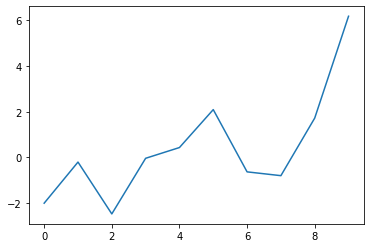

In [45]:
pd.Series(b).plot()

In [32]:
import numpy as np
np.dot(wem_model[['a','b','c']].T, [1,0,0]) == wem_model['a']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from compare_tools import fakebook
from compare_tools.hathimeta import clean_description
from htrc_features import Volume
meta = pd.read_csv('../../sampling/test_dataset.csv.gz', low_memory=False)
ground_truth = []
meta.page_count.quantile([.1,.2,.3,.4,.5,.6,.7,.75, .8, .85, .9, .95])

0.10     56.0
0.20    124.0
0.30    192.0
0.40    248.0
0.50    302.0
0.60    352.0
0.70    410.0
0.75    444.0
0.80    488.0
0.85    538.0
0.90    612.0
0.95    742.0
Name: page_count, dtype: float64

## Combining Books

Antology Criteria - multiple works by an author that are different and relatively short.

Combined Volumes criteria - multiple works that look to be parts of a sequential set.

### Anthologies

Choose one book and patch it with other books where the title seems notably different.

In [2]:
pool = meta[meta.page_count < meta.page_count.quantile(.4)]
pool = pool.drop_duplicates(['author', 'title'])
acounts = pool.groupby('author').title.count()
pool = pool[pool.author.isin(acounts[acounts > 2].index)]
pool.shape

(39124, 27)

Choose 1 author and return all their books.

In [ ]:
i = 0
for groupname, subset in pool.groupby('author'):
    to_combine1 = fakebook.anthology_sample(subset)
    to_combine2 = fakebook.anthology_sample(subset)
    
    new_ids = []
    # Check if there's an OVERLAP relationship
    overlap = set(to_combine1).intersection(to_combine2)
    if (len(overlap) < 1) or (len(overlap) > 2):
        # Don't bother making the second fake doc
        to_combine2 = []
    
    for to_combine in [to_combine1, to_combine2]:
        if len(to_combine) > 1:
            try:
                volmeta, tl = fakebook.combine_books(to_combine)
            except KeyboardInterrupt:
                raise
            except:
                continue

            new_ids.append(volmeta['id'])
            fakebook.save_fake_vol(volmeta, tl, '/data/saddl/fakebooks/')
            for source_htid in volmeta['source_htids']:
                ground_truth.append(dict(left=volmeta['id'], right=source_htid, judgment='CONTAINS', notes='fake anthology'))
                ground_truth.append(dict(left=source_htid, right=volmeta['id'], judgment='PARTOF', notes='fake anthology'))
        i += 1
        if i % 100 == 0:
            print(i, groupname)
            
    if len(new_ids) == 2:
        ground_truth.append(dict(left=new_ids[1], right=new_ids[0], judgment='OVERLAPS', notes='fake overlap'))
        ground_truth.append(dict(left=new_ids[0], right=new_ids[1], judgment='OVERLAPS', notes='fake overlap'))

100 Aldan, Daisy.
200 American Municipal Association.
300 Association of State Universities and Land-Grant Colleges.
400 Baldwin, Richard E.
500 Barzun, Jacques, 1907-
600 Bengough, J. W. 1851-1923.
700 Birney, William, 1819-1907.
800 Borchard, Edwin Montefiore, 1884-1951.
900 Brainerd, Ezra, 1844-1924.
1000 Brooks, Stewart M.
1100 Burk, W. Herbert 1867-1933.
1200 Caldwell, Esther.
1300 Carnegie Institute. Department of Fine Arts.


### Multi-volume sets

In [ ]:
pool = meta[meta.page_count < meta.page_count.quantile(.6)]
pool = pool[~pool.description.isna()]
pool = pool[clean_description(pool.description).str.contains('^v\.\d\d?$')]
# Filter to author/title pairs that have more than one volume
pool = pool.groupby(['author', 'title']).filter(lambda x: x.description.unique().shape[0] > 1)
pool = pool.copy()
pool['descint'] = clean_description(pool.description).str.replace('v.', '').astype(int)
# Filter further, to author/title pairs that have consecutively numbered volumes
def has_consecutive_v(x):
    sorted_v_ints = x.descint.sort_values()
    cumulative_run_length = ((sorted_v_ints - 1) == sorted_v_ints.shift(1))
    return cumulative_run_length.any()
pool = pool.groupby(['author', 'title']).filter(has_consecutive_v)
pool.shape

In [ ]:
i = 0
for groupname, subset in pool.groupby(['author', 'title']):
    smaller_subset = subset.copy().groupby('descint').apply(lambda x: x.sample(1))
    for to_combine in fakebook.consecutive_vol_samples(smaller_subset):
        if len(to_combine) > 1:
            try:
                volmeta, tl = fakebook.combine_books(to_combine, style='multivol')
            except KeyboardInterrupt:
                raise
            except:
                continue
            fakebook.save_fake_vol(volmeta, tl, '/data/saddl/fakebooks/')
            for source_htid in volmeta['source_htids']:
                ground_truth.append(dict(left=volmeta['id'], right=source_htid, judgment='CONTAINS', notes='fake multivol'))
                ground_truth.append(dict(left=source_htid, right=volmeta['id'], judgment='PARTOF', notes='fake multivol'))
    i += 1
    if i % 100 == 0:
        print(i, groupname)

In [ ]:
df = pd.DataFrame(ground_truth)
df.to_parquet('/data/saddl/fakebooks/fakebook_gt.parquet')
df.sample(10)

In [ ]:
to_save = df.left[df.left.str.startswith('fake')].drop_duplicates()
to_save.name = 'htid'
to_save.to_csv('/data/saddl/fakebooks/fake-htids.csv', header=True, index=False)

In [4]:
# Create a stat crunching list
import json
import pandas as pd
df = pd.read_parquet('/data/saddl/fakebooks/fakebook_gt.parquet')
with open('/data/saddl/fakebooks/stat_input.json', mode='w') as f:
    for record in df.sort_values('left').to_dict(orient='records'):
        json.dump(record, f)
        f.write('\n')